## Initial modeling - just count vectorizer w/ bag of words

Let's do some modeling!

http://cogcomp.cs.illinois.edu/sites/mclc/abstracts/abstract008.pdf


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import datetime as dt
import dateutil.parser
import re
from pymongo import MongoClient
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_union
from sklearn.base import TransformerMixin
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
paras_re = re.compile(" (\([^\)]+\))")
def create_ts(frag_list):
    '''Helper function to create whole transcript from list of fragments'''
    #join all fragments
    frags = [x[0] for x in frag_list[0]]
    transcript = " ".join(frags)
    #clean out (Applause), (Laughter), stuff in parentheses
    transcript = re.sub(paras_re, "", transcript)
    return transcript

Import all TED transcript (from scraping). Drop all the talks with no transcript, and merge all the transcripts into one string. Label TED talks as "Not Boring", or Boring = 0. 

In [ ]:
df = pd.read_pickle('transcripts.df')

In [ ]:
df.rename(columns = {'transcripts':'frag_list'}, inplace=True)
df.drop(df[pd.isnull(df.frag_list)].index, axis = 0, inplace=True)
df['transcripts'] = df.frag_list.apply(create_ts)
df.drop(df[df.transcripts.apply(len)<500].index, inplace=True)
df.reset_index(drop = True, inplace=True)
df['boring'] = 0

Import all Yale Open transcripts (also from scraping). Label Yale Open transcripts as boring, or Boring = 1. 

(Honestly, after reading through some of the transcripts, they're pretty engaging... But let's run with this assumption for the sake of this project.)

In [131]:
yale_df = pd.read_pickle('lect_transcripts.p',)
yale_df = pd.DataFrame(yale_df, columns = ['transcripts'])
yale_df['boring'] = 1

Combine ALL the talks!

In [575]:
total_df = pd.concat([df[['transcripts', 'boring']], yale_df[['transcripts', 'boring']]])
total_df.reset_index(drop=True, inplace=True)

Prepare ALL the pipeline transformers!

5 things will happen to the data:
1. Scrub the data. We need to scrub easy things for the model to detect - words like "professor", "student", and some names that keep popping up. 
2. Sample the data. We're only going to use bag of words, so we can make all transcripts - TED talks and Yale lectures - the same length by randomly sampling 5000 words from every transcript.
3. TFIDF - bag of words, with word frequency normalized. 
4. SVD - Reduce dimensionality so the model has an easier time. Also, it'll be very interesting to see what topics come out of SVD. 
5. Model with Random Forest. It will also be very interesting to see what transformed features random forest thinks is very important. 

In [15]:

def ts_samples(ts):
    """Samples 5000 words from a transcript"""
    return " ".join(np.random.choice(ts.split(" "), size=5000))
def scrubber(ts):
    re_list = []
    re_list.append(re.compile(r'[Pp]rofessor '))
    re_list.append(re.compile(r'[mM]ichael '))
    re_list.append(re.compile(r'[Mm]c[Bb]ride'))
    re_list.append(re.compile(r'[Ss]tudent'))
    for i in re_list:
        ts = re.sub(i, '', ts)
    return ts

class LectScrubber(TransformerMixin):
    def transform(self, X, **transform_params): 
        return pd.Series(X.apply(scrubber))
    def fit(self, X, y=None, **fit_params):
        return self

class Sampler(TransformerMixin):
    def transform(self, X, **transform_params): 
        return pd.Series(X.apply(ts_samples))
    def fit(self, X, y=None, **fit_params):
        return self

Train ALL (just one, actually) the models!

In [9]:
X = total_df.transcripts
y = total_df.boring
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RandomForestClassifier(n_estimators = 20)

pipe = Pipeline([
            ('scub', LectScrubber()),
            ('sampler', Sampler()),
            ('feats', FeatureUnion([
                ('lsa', Pipeline([
                        ("count_vect", TfidfVectorizer(max_df = 0.97, min_df = 0.02, stop_words = 'english')),
                        ('svd', TruncatedSVD(100))
                               ]))
                            ])),
            ('rfc', model)
                ])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.93085655314757487

ROC curve?

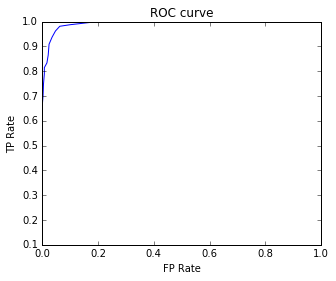

In [10]:
pred_vals = pipe.predict_proba(X_test)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 5, 4
#pr_curve(y_test, pred_vals[:,1])
roc = roc_curve(y_test, pred_vals[:,1])
plt.plot(roc[0], roc[1])
plt.title('ROC curve')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

Okay, let's figure out why this score is so high.

Let's redo our pipeline and try to see inside of it. 

In [18]:
scrubb = LectScrubber()
sampler = Sampler()
tfidf = TfidfVectorizer(max_df = 0.97, min_df = 0.02, stop_words = 'english')
svd = TruncatedSVD(100)

scrubbed = scrubb.transform(X)
sampled = sampler.transform(scrubbed)
tfidfed = tfidf.fit_transform(sampled)
svded = svd.fit_transform(tfidfed)

svd_df = pd.DataFrame(svded)
svd_df['label'] = total_df.boring

We can look at the distribution for each "topic" now.

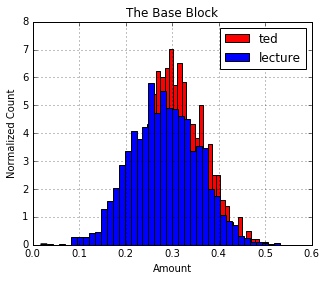

In [62]:
col = 0
svd_df[svd_df.label == 1][col].hist(bins = 40, normed = True, color = 'r', label = 'ted')

svd_df[svd_df.label == 0][col].hist(bins = 40, normed = True, color = 'b', label = 'lecture')

plt.legend()
tit = "Histogram of Block " + str(col+1)
plt.title('The Base Block')
plt.xlabel('Amount')
plt.ylabel('Normalized Count')

### Looking at topics/importances

In [60]:
comps = pipe.named_steps['feats'].transformer_list[0][1].named_steps['svd'].components_
feats = pipe.named_steps['feats'].transformer_list[0][1].named_steps['count_vect'].get_feature_names()
sorted(zip(comps[3], feats), key = lambda x: abs(x[0]), reverse = True)

[(-0.19860055119770514, u'brain'),
 (0.1586170937966857, u'bond'),
 (-0.1429317648984316, u'cells'),
 (0.11985476550015468, u'carbon'),
 (0.11306338148414437, u'market'),
 (-0.10831675325099722, u'music'),
 (0.1069467131200694, u'energy'),
 (0.10415309458433925, u'going'),
 (-0.10367573232058117, u'like'),
 (0.10157772218842274, u'price'),
 (0.096700866885222558, u'rate'),
 (0.09628334765047479, u'money'),
 (-0.095265716646365781, u'life'),
 (-0.09481753612431354, u'body'),
 (0.092243567739447349, u'war'),
 (0.092014124431345198, u'government'),
 (-0.09199798568262936, u'love'),
 (0.088289156892166459, u'state'),
 (0.085739691217439476, u'right'),
 (-0.081539694187703002, u'cancer'),
 (0.07896904993815633, u'okay'),
 (0.077975349417158876, u'law'),
 (0.076995321993850716, u'bonds'),
 (0.076504821683275562, u'value'),
 (0.072324253458584495, u'countries'),
 (-0.072030984745102139, u'design'),
 (-0.071653801008214529, u'poem'),
 (-0.07157744131053953, u'cell'),
 (0.070280573049670822, u'

In [28]:
imps = sorted(zip(pipe.named_steps['rfc'].feature_importances_, range(100)), key = lambda x: x[0], reverse=True)
imps

[(0.12789491691055788, 2),
 (0.081769173216654958, 1),
 (0.078587715158521962, 3),
 (0.043799849844080876, 7),
 (0.03974693262533411, 11),
 (0.038546679742691409, 8),
 (0.034034803996544967, 9),
 (0.032602788209471094, 17),
 (0.03206786328944447, 5),
 (0.029307560892870482, 13),
 (0.020728517962562813, 10),
 (0.020084258107412351, 18),
 (0.018779729917327546, 12),
 (0.018302321313284624, 22),
 (0.017039128419357348, 15),
 (0.011867107897781896, 4),
 (0.011728910265437549, 20),
 (0.011084236556448357, 26),
 (0.010314927477907767, 16),
 (0.0099894492616193296, 0),
 (0.0091257755007326091, 56),
 (0.008117132306775755, 40),
 (0.0078363770576588658, 21),
 (0.0077091913284357896, 27),
 (0.0074146008879501738, 37),
 (0.0072241034462312654, 57),
 (0.0071672530659157045, 49),
 (0.0070699874634532938, 23),
 (0.0067301379983237247, 25),
 (0.0066584551153192314, 93),
 (0.0059909215785154245, 14),
 (0.0059589937360207306, 32),
 (0.0058609734721394051, 46),
 (0.0055797894421620959, 35),
 (0.00546721